In [154]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import albumentations
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import joblib

from torch.utils.data import DataLoader, Dataset
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from torchvision import transforms, datasets
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from torch.utils.tensorboard import SummaryWriter

### Data Loder

In [155]:
#https://debuggercafe.com/creating-efficient-image-data-loaders-in-pytorch-for-deep-learning/

In [156]:
transfrom=transforms.Compose([transforms.Resize(224),
                        transforms.CenterCrop(224),
                             transforms.ToTensor()])

In [157]:
class ImageDataset(Dataset):
    
    def __init__(self, path, labels, tfms=None):
        # data loading
        self.X = path
        self.y = labels
        
    def __getitem__(self, index):
        # dataset[0]
        image = Image.open(self.X[index]).convert('RGB')
        image = transfrom(image)
        #image = np.transpose(image, (2, 0, 1))
        type(image)
        label = self.y[index]
        return image, torch.tensor(label, dtype=torch.long)
        
    def __len__(self):
        # len(dataset)
        return(len(self.X))
    

### Model(DensNet)

In [158]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [159]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

In [160]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [161]:
b1 = nn.Sequential(
    nn.Conv2d(3, 224, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(224), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [162]:
num_channels, growth_rate = 224, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that haves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

### Model Traning

In [163]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [164]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 2))

In [165]:
#create TensorBorad
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/old_text_image_experiment_1', flush_secs=1)

In [166]:
df = pd.read_csv('../input/data.csv')
X_ = df.image_path.values
y_ = df.target.values

In [167]:
#TODO Splite data on train and test
(xtrain, xtest, ytrain, ytest) = train_test_split(X_, y_,test_size=0.25, random_state=42)


In [168]:
train_dataset = ImageDataset(xtrain, ytrain, 0)

In [169]:
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=100)

In [170]:
def train(net, train_iter, num_epochs, lr):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
           torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
         running_loss = 0.0
         running_correct = 0
        # Sum of training loss, sum of training accuracy, no. of examples
         for i ,(X, y) in enumerate(train_data):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)

            l = loss(y_hat, y)
            running_loss += l.item()
            running_correct += get_num_correct(y_hat, y)
            
            l.backward()
            optimizer.step()
            #fore Tensorborad
            

         writer.add_scalar('training loss',
                    running_loss,
                    epoch)
         writer.add_scalar('training correct',
                    running_correct,
                    epoch)
        # log the epoch accuracy
         writer.add_scalar('training accuracy',
                    running_correct/len(train_data),
                    epoch)
        
         for name, weight in net.named_parameters():
           writer.add_histogram(name,weight, epoch)
           writer.add_histogram(f'{name}.grad',weight.grad, epoch)
        
         print(f"Epoch {epoch+1} train loss: {running_loss/len(train_data):.3f} train acc: {running_correct/len(train_data)}")
    print('Finished Training')

In [171]:
lr, num_epochs, batch_size = 0.1, 10, 256
train(net, train_data, num_epochs, lr)
torch.save(net.state_dict(), 'mlp.params')

training on cuda:0
Epoch 1 train loss: 1.219 train acc: 36.0
Epoch 2 train loss: 25.709 train acc: 11.0
Epoch 3 train loss: 14.426 train acc: 36.0
Epoch 4 train loss: 7.018 train acc: 36.0
Epoch 5 train loss: 4.226 train acc: 36.0
Epoch 6 train loss: 2.329 train acc: 36.0
Epoch 7 train loss: 0.825 train acc: 40.0
Epoch 8 train loss: 0.292 train acc: 41.0
Epoch 9 train loss: 0.185 train acc: 42.0
Epoch 10 train loss: 0.338 train acc: 40.0
Finished Training


### Evaluation Model

In [172]:
def create_confusion_matrix(y_true, y_predicted):
    return confusion_matrix(y_true, y_predicted)

In [173]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.get_cmap('Blues')): 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(ticks=range(cm.min(), cm.max() + 1))

    target_names = ['0', '1']
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True value')
    plt.xlabel('Predicted value\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [174]:
train_dataset = ImageDataset(xtrain, ytrain, 0)
train_data = torch.utils.data.DataLoader(train_dataset)

In [175]:
#X = []
#y = []
net.to('cpu')
y_true = []
y_predicted = []
softmax = nn.Softmax(dim=1)
for (image, label) in train_data:
    y_true.append(label.detach())
    y_predicted_tensor = net(image)
    y_predicted_tensor = softmax(y_predicted_tensor)
    y_predicted.append(torch.max(y_predicted_tensor).detach())

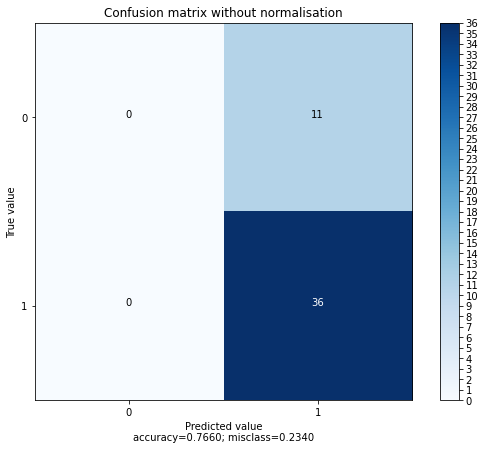

In [176]:
cm = create_confusion_matrix(y_true, y_predicted)
plot_confusion_matrix(cm, 'Confusion matrix without normalisation')

In [177]:
dataiter = iter(train_data)
images, labels = dataiter.next()


In [178]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


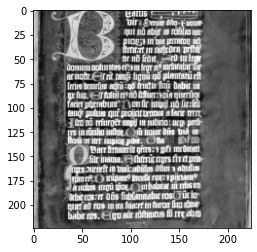

In [179]:
# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('old_text_image_images', img_grid)
net.to('cpu')
writer.add_graph(net, images)